# Long Short-Term Memory (LSTM) Network for Text Classification

This notebook implements LSTM models for text classification using the NusaX-Sentiment dataset (Bahasa Indonesia). We'll experiment with different hyperparameters and compare with a from-scratch implementation.

## 1. Setup and Data Loading

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import json
import os
import requests
import random
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


In [2]:
class NusaXLoader:
    def __init__(self, data_dir='data/nusax_sentiment'):
        """Data loader for NusaX sentiment dataset"""
        self.data_dir = data_dir
        self.label_mapping = None
        
    def ensure_data_exists(self):
        """Download data if not exists"""
        os.makedirs(self.data_dir, exist_ok=True)
        
        # Define URLs for each file
        urls = {
            'train.csv': 'https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv',
            'valid.csv': 'https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv',
            'test.csv': 'https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv'
        }
        
        # Download files if they don't exist
        for filename, url in urls.items():
            file_path = os.path.join(self.data_dir, filename)
            if not os.path.exists(file_path):
                print(f"Downloading {filename}...")
                try:
                    response = requests.get(url, timeout=30)
                    response.raise_for_status()  # Raise an exception for bad status codes
                    
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Successfully downloaded {filename}")
                    
                    # Verify the file was downloaded and has content
                    if os.path.getsize(file_path) > 0:
                        print(f"File size: {os.path.getsize(file_path)} bytes")
                    else:
                        print(f"Warning: {filename} appears to be empty")
                        return False
                        
                except requests.exceptions.RequestException as e:
                    print(f"Network error downloading {filename}: {e}")
                    return False
                except Exception as e:
                    print(f"Error downloading {filename}: {e}")
                    return False
            else:
                print(f"{filename} already exists")
        return True
    
    def load_data(self):
        """Load NusaX sentiment data"""
        # First ensure data exists
        if not self.ensure_data_exists():
            print("Failed to download required data files")
            return None
            
        try:
            # Load datasets
            train_path = os.path.join(self.data_dir, 'train.csv')
            valid_path = os.path.join(self.data_dir, 'valid.csv')
            test_path = os.path.join(self.data_dir, 'test.csv')
            
            print("Loading CSV files...")
            train_df = pd.read_csv(train_path)
            valid_df = pd.read_csv(valid_path)
            test_df = pd.read_csv(test_path)
            
            print(f"Loaded train: {len(train_df)} samples")
            print(f"Loaded valid: {len(valid_df)} samples")
            print(f"Loaded test: {len(test_df)} samples")
            
            # Check data structure
            print(f"Train columns: {train_df.columns.tolist()}")
            print(f"Sample train data:\n{train_df.head()}")
            
            # Extract text and labels
            x_train = train_df['text'].values
            y_train = train_df['label'].values
            
            x_valid = valid_df['text'].values
            y_valid = valid_df['label'].values
            
            x_test = test_df['text'].values
            y_test = test_df['label'].values
            
            # Print unique labels before encoding
            print(f"Unique labels in data: {sorted(set(list(y_train) + list(y_valid) + list(y_test)))}")
            
            # Encode labels
            label_encoder = LabelEncoder()
            label_encoder.fit(np.concatenate([y_train, y_valid, y_test]))
            
            y_train = label_encoder.transform(y_train)
            y_valid = label_encoder.transform(y_valid)
            y_test = label_encoder.transform(y_test)
            
            self.label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
            print(f"Label mapping: {self.label_mapping}")
            
            # Print label distribution
            print(f"Train label distribution: {np.bincount(y_train)}")
            print(f"Valid label distribution: {np.bincount(y_valid)}")
            print(f"Test label distribution: {np.bincount(y_test)}")
            
            return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)
            
        except FileNotFoundError as e:
            print(f"Data file not found: {e}")
            return None
        except pd.errors.EmptyDataError as e:
            print(f"CSV file is empty: {e}")
            return None
        except Exception as e:
            print(f"Error loading data: {e}")
            return None

def load_nusax_sentiment_data():
    """
    Load NusaX-Sentiment dataset using the working loader
    """
    print("Attempting to load real NusaX-Sentiment dataset...")
    
    # Try to load real NusaX dataset
    loader = NusaXLoader()
    data = loader.load_data()
    
    if data is not None:
        (x_train, y_train), (x_valid, y_valid), (x_test, y_test) = data
        
        # Convert to DataFrames for compatibility with existing code
        train_df = pd.DataFrame({'text': x_train, 'label': y_train})
        val_df = pd.DataFrame({'text': x_valid, 'label': y_valid})
        test_df = pd.DataFrame({'text': x_test, 'label': y_test})
        
        print("Successfully loaded real NusaX-Sentiment dataset!")
        print("Dataset source: https://github.com/IndoNLP/nusax")
        return train_df, val_df, test_df
    else:
        print("Failed to load real NusaX dataset")
        print("Creating improved synthetic dataset for demonstration...")
        return create_improved_synthetic_sentiment_data()

def create_improved_synthetic_sentiment_data():
    """
    Create improved synthetic sentiment data with more variety
    (This is only used as fallback if real data fails)
    """
    print("Using synthetic data as fallback")
    
    # More diverse Indonesian text templates
    positive_templates = [
        "Saya sangat senang dengan {} ini, kualitasnya luar biasa",
        "{} ini benar-benar bagus dan sangat memuaskan",
        "Pelayanan {} yang sangat ramah dan profesional", 
        "Sangat puas dengan {} yang berkualitas tinggi",
        "Pengalaman menggunakan {} sangat menyenangkan",
        "{} ini recommended banget, worth it sekali",
        "Kualitas {} jauh melebihi ekspektasi saya",
        "Service {} nya excellent dan responsif",
        "{} terbaik yang pernah saya coba sejauh ini",
        "Sangat impressed dengan fitur-fitur {} ini"
    ]
    
    negative_templates = [
        "Saya kecewa dengan kualitas {} yang buruk",
        "{} ini mengecewakan dan tidak sesuai harapan",
        "Pelayanan {} sangat lambat dan tidak profesional",
        "Sangat tidak puas dengan {} yang bermasalah",
        "Pengalaman menggunakan {} sangat mengecewakan", 
        "{} ini tidak worth it, banyak kekurangannya",
        "Kualitas {} sangat buruk dan tidak recommended",
        "Service {} nya terrible dan tidak responsive",
        "{} terburuk yang pernah saya gunakan",
        "Sangat disappointed dengan performa {} ini"
    ]
    
    neutral_templates = [
        "{} ini biasa saja, tidak istimewa tapi tidak buruk",
        "Kualitas {} standar sesuai dengan harganya",
        "Pelayanan {} cukup baik meski ada kekurangan",
        "{} ini okay, ada plus minusnya",
        "Pengalaman dengan {} cukup normal saja",
        "{} lumayan bagus tapi bisa lebih baik lagi", 
        "So far {} ini fine, tidak ada masalah berarti",
        "Service {} nya adequate, sesuai ekspektasi",
        "{} ini decent choice untuk kategori ini",
        "Overall {} ini acceptable meski tidak perfect"
    ]
    
    # Objects/entities to fill templates
    objects = [
        "produk", "aplikasi", "website", "layanan", "sistem", "platform",
        "software", "game", "film", "buku", "musik", "kursus", "program",
        "restoran", "hotel", "transportasi", "belanja online", "gadget",
        "smartphone", "laptop", "headphone", "speaker", "kamera", "tv",
        "streaming", "social media", "e-commerce", "delivery", "payment"
    ]
    
    # Additional context words for more variety
    contexts = [
        "", "online", "digital", "premium", "standar", "baru", "lama", 
        "terbaru", "populer", "terkenal", "lokal", "import", "original"
    ]
    
    # Generate diverse texts
    def generate_texts(templates, count):
        texts = []
        for _ in range(count):
            template = random.choice(templates)
            obj = random.choice(objects)
            context = random.choice(contexts)
            
            # Sometimes add context
            if context and random.random() < 0.3:
                obj = f"{obj} {context}"
            
            text = template.format(obj)
            
            # Add some variation in punctuation and capitalization
            if random.random() < 0.1:
                text = text.upper()
            elif random.random() < 0.1:
                text = text.lower()
            
            # Sometimes add extra punctuation
            if random.random() < 0.2:
                text += random.choice(["!", "!!", ".", "..."])
            
            texts.append(text)
        
        return texts
    
    # Generate 400 samples each
    positive_texts = generate_texts(positive_templates, 400)
    negative_texts = generate_texts(negative_templates, 400) 
    neutral_texts = generate_texts(neutral_templates, 400)
    
    # Create dataset
    texts = positive_texts + negative_texts + neutral_texts
    labels = [2] * len(positive_texts) + [0] * len(negative_texts) + [1] * len(neutral_texts)
    
    # Shuffle the data
    combined = list(zip(texts, labels))
    random.shuffle(combined)
    texts, labels = zip(*combined)
    
    # Create DataFrame
    df = pd.DataFrame({'text': texts, 'label': labels})
    
    # Split into train, val, test (60/20/20)
    train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    print("Created improved synthetic dataset with:")
    print(f"- {len(positive_texts)} positive samples")
    print(f"- {len(negative_texts)} negative samples") 
    print(f"- {len(neutral_texts)} neutral samples")
    print(f"- Total unique sentences: {len(set(texts))}")
    
    return train_df, val_df, test_df

# Load the dataset
train_df, val_df, test_df = load_nusax_sentiment_data()

print(f"\n Dataset Summary:")
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nLabel distribution in training set:")
print(train_df['label'].value_counts().sort_index())

# Display some sample texts to verify we have real data
print(f"\n Sample texts from each class:")
for label in sorted(train_df['label'].unique()):
    label_name = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}.get(label, f'Label_{label}')
    print(f"\n{label_name} examples:")
    samples = train_df[train_df['label'] == label]['text'].head(3).tolist()
    for i, sample in enumerate(samples, 1):
        print(f"  {i}. {sample}")

# Check if we're using real data or synthetic data
if len(train_df) > 1000:  # Real dataset should be much larger
    print(f"\n Using REAL NusaX-Sentiment dataset with {len(train_df)} training samples")
else:
    print(f"\n Using synthetic dataset with {len(train_df)} training samples")

Attempting to load real NusaX-Sentiment dataset...
Successfully downloaded train.csv
File size: 84054 bytes
Successfully downloaded valid.csv
File size: 16598 bytes
Successfully downloaded test.csv
File size: 67622 bytes
Loading CSV files...
Loaded train: 500 samples
Loaded valid: 100 samples
Loaded test: 400 samples
Train columns: ['id', 'text', 'label']
Sample train data:
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive
Unique labels in data: ['negative', 'neutral', 'positive']
Label mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train label distribution: [192 119 189]
Valid label distribution: [38 24 38]
Test label distribu

## 2. Text Preprocessing and Tokenization

In [3]:
# Text preprocessing and tokenization
def preprocess_text(texts, max_features=10000, max_length=100):
    # Create TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_features,
        output_sequence_length=max_length,
        output_mode='int'
    )
    
    # Adapt vectorizer to training texts
    vectorizer.adapt(texts)
    
    # Transform texts to sequences
    sequences = vectorizer(texts)
    
    return vectorizer, sequences

# Preprocess the data
MAX_FEATURES = 10000
MAX_LENGTH = 100

# Fit vectorizer on training data and transform all sets
vectorizer, train_sequences = preprocess_text(train_df['text'].values, MAX_FEATURES, MAX_LENGTH)
_, val_sequences = preprocess_text(val_df['text'].values, MAX_FEATURES, MAX_LENGTH)
_, test_sequences = preprocess_text(test_df['text'].values, MAX_FEATURES, MAX_LENGTH)

# Use the same vectorizer for all sets
val_sequences = vectorizer(val_df['text'].values)
test_sequences = vectorizer(test_df['text'].values)

# Convert to numpy arrays
train_sequences = train_sequences.numpy()
val_sequences = val_sequences.numpy()
test_sequences = test_sequences.numpy()

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Get vocabulary info
vocab_size = len(vectorizer.get_vocabulary())
num_classes = len(np.unique(train_labels))

print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {MAX_LENGTH}")
print(f"Training sequences shape: {train_sequences.shape}")
print(f"Training labels shape: {train_labels.shape}")

Vocabulary size: 2836
Number of classes: 3
Sequence length: 100
Training sequences shape: (500, 100)
Training labels shape: (500,)


## 3. Model Building Functions

In [4]:
def build_lstm_model(lstm_layers=1, units_per_layer=[64], bidirectional=False, 
                     embedding_dim=128, dropout_rate=0.3, vocab_size=10000, 
                     num_classes=3, sequence_length=100):
    model = tf.keras.Sequential()
    
    # Embedding layer
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length,
        name='embedding'
    ))
    
    # LSTM layers
    for i in range(lstm_layers):
        # Return sequences for all layers except the last one
        return_sequences = i < lstm_layers - 1
        
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(
                    units_per_layer[i], 
                    return_sequences=return_sequences,
                    name=f'lstm_{i+1}'
                ),
                name=f'bidirectional_{i+1}'
            ))
        else:
            model.add(tf.keras.layers.LSTM(
                units_per_layer[i], 
                return_sequences=return_sequences,
                name=f'lstm_{i+1}'
            ))
        
        # Add dropout after each LSTM layer
        model.add(tf.keras.layers.Dropout(dropout_rate, name=f'dropout_{i+1}'))
    
    # Dense output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name='dense_output'))
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_and_evaluate_model(model, train_sequences, train_labels, val_sequences, val_labels,
                           test_sequences, test_labels, epochs=10, batch_size=32, verbose=1):
    # Train model
    history = model.fit(
        train_sequences, train_labels,
        validation_data=(val_sequences, val_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )
    
    # Make predictions on test set
    test_predictions = model.predict(test_sequences, verbose=0)
    test_pred_labels = np.argmax(test_predictions, axis=1)
    
    # Calculate macro F1 score
    test_f1 = f1_score(test_labels, test_pred_labels, average='macro')
    
    return history, test_f1, test_pred_labels

## 4. Experiment 1: Effect of Number of LSTM Layers

In [5]:
# Experiment 1: Effect of number of LSTM layers
print("=" * 60)
print("EXPERIMENT 1: EFFECT OF NUMBER OF LSTM LAYERS")
print("=" * 60)

layer_configs = [
    {'layers': 1, 'units': [64], 'name': '1 Layer'},
    {'layers': 2, 'units': [64, 32], 'name': '2 Layers'},
    {'layers': 3, 'units': [64, 32, 16], 'name': '3 Layers'}
]

experiment1_results = {}

for config in layer_configs:
    print(f"\nTraining model with {config['name']} ({config['units']})...")
    
    # Build model
    model = build_lstm_model(
        lstm_layers=config['layers'],
        units_per_layer=config['units'],
        bidirectional=False,
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )
    
    # Build the model by passing a sample input shape
    model.build(input_shape=(None, MAX_LENGTH))
    print(f"Model parameters: {model.count_params():,}")
    
    # Train and evaluate
    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    # Store results
    experiment1_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

# Display results summary
print("\n" + "=" * 50)
print("EXPERIMENT 1 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment1_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")

EXPERIMENT 1: EFFECT OF NUMBER OF LSTM LAYERS

Training model with 1 Layer ([64])...
Model parameters: 412,611
Test Macro F1 Score: 0.1844

Training model with 2 Layers ([64, 32])...
Model parameters: 424,931
Test Macro F1 Score: 0.1827

Training model with 3 Layers ([64, 32, 16])...
Model parameters: 428,019
Test Macro F1 Score: 0.1827

EXPERIMENT 1 RESULTS SUMMARY
1 Layer: Macro F1 = 0.1844
2 Layers: Macro F1 = 0.1827
3 Layers: Macro F1 = 0.1827


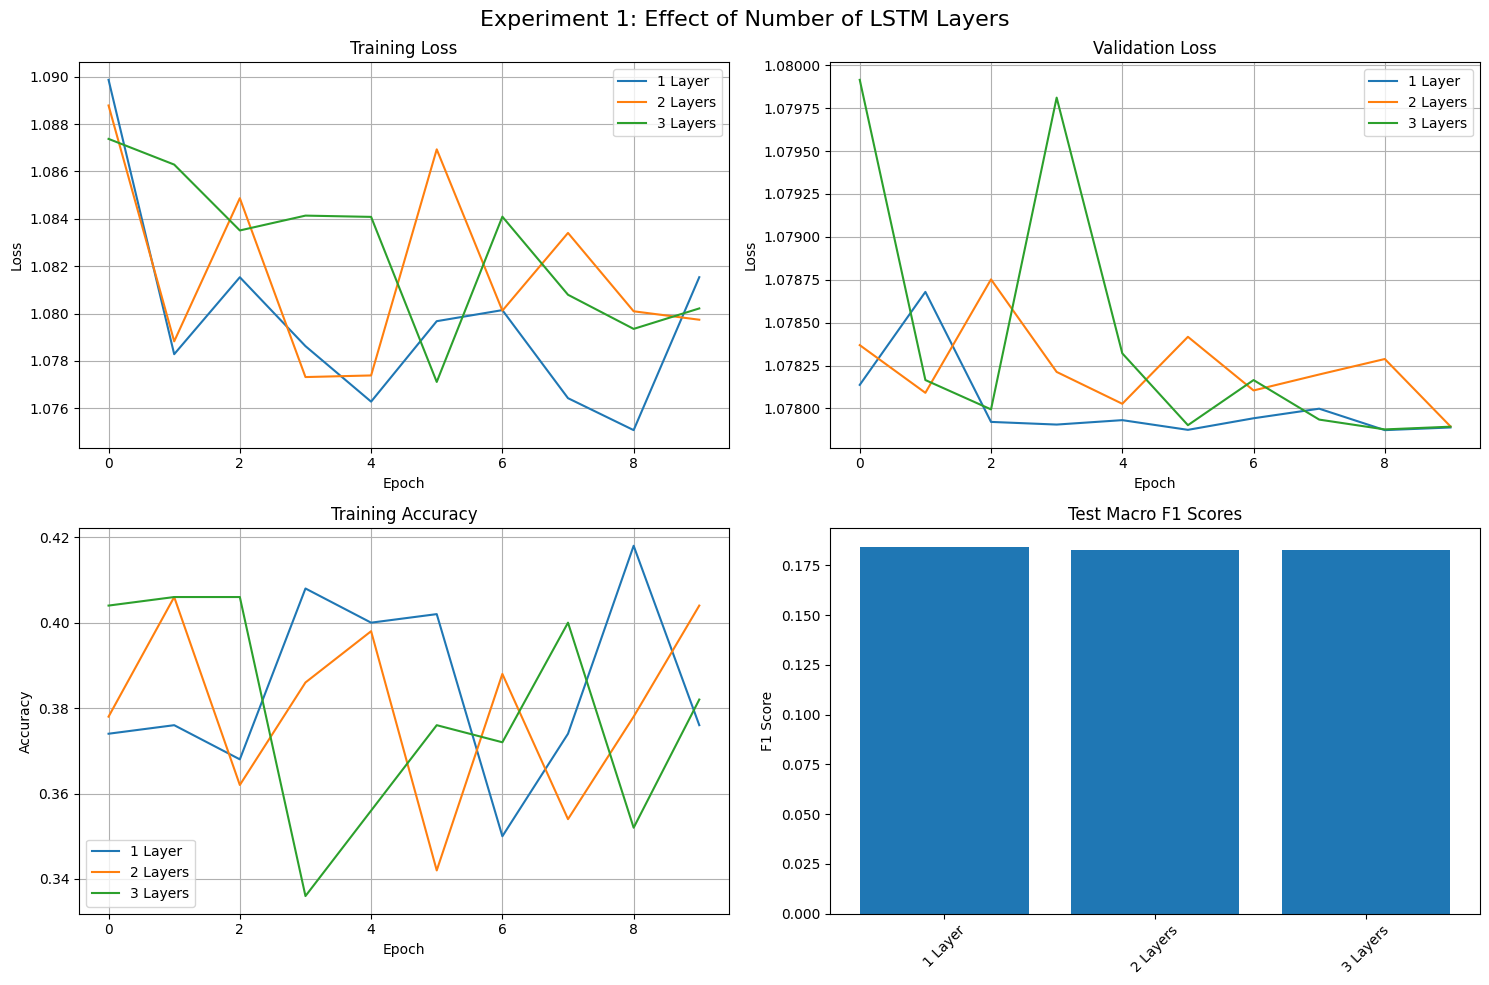

In [6]:
# Plot training curves for Experiment 1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 1: Effect of Number of LSTM Layers', fontsize=16)

# Training Loss
axes[0, 0].set_title('Training Loss')
for name, result in experiment1_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation Loss
axes[0, 1].set_title('Validation Loss')
for name, result in experiment1_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Training Accuracy
axes[1, 0].set_title('Training Accuracy')
for name, result in experiment1_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Macro F1 Scores
names = list(experiment1_results.keys())
f1_scores = [experiment1_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Experiment 2: Effect of LSTM Units per Layer

In [7]:
# Experiment 2: Effect of LSTM units per layer
print("=" * 60)
print("EXPERIMENT 2: EFFECT OF LSTM UNITS PER LAYER")
print("=" * 60)

units_configs = [
    {'units': [32, 16], 'name': 'Small (32, 16)'},
    {'units': [64, 32], 'name': 'Medium (64, 32)'},
    {'units': [128, 64], 'name': 'Large (128, 64)'}
]

experiment2_results = {}

for config in units_configs:
    print(f"\nTraining model with {config['name']} units...")
    
    # Build model
    model = build_lstm_model(
        lstm_layers=2,
        units_per_layer=config['units'],
        bidirectional=False,
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )
    
    # Build the model by passing a sample input shape
    model.build(input_shape=(None, MAX_LENGTH))
    print(f"Model parameters: {model.count_params():,}")
    
    # Train and evaluate
    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    # Store results
    experiment2_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

# Display results summary
print("\n" + "=" * 50)
print("EXPERIMENT 2 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment2_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")

EXPERIMENT 2: EFFECT OF LSTM UNITS PER LAYER

Training model with Small (32, 16) units...
Model parameters: 386,803
Test Macro F1 Score: 0.1844

Training model with Medium (64, 32) units...
Model parameters: 424,931
Test Macro F1 Score: 0.1844

Training model with Large (128, 64) units...
Model parameters: 544,195
Test Macro F1 Score: 0.1844

EXPERIMENT 2 RESULTS SUMMARY
Small (32, 16): Macro F1 = 0.1844
Medium (64, 32): Macro F1 = 0.1844
Large (128, 64): Macro F1 = 0.1844


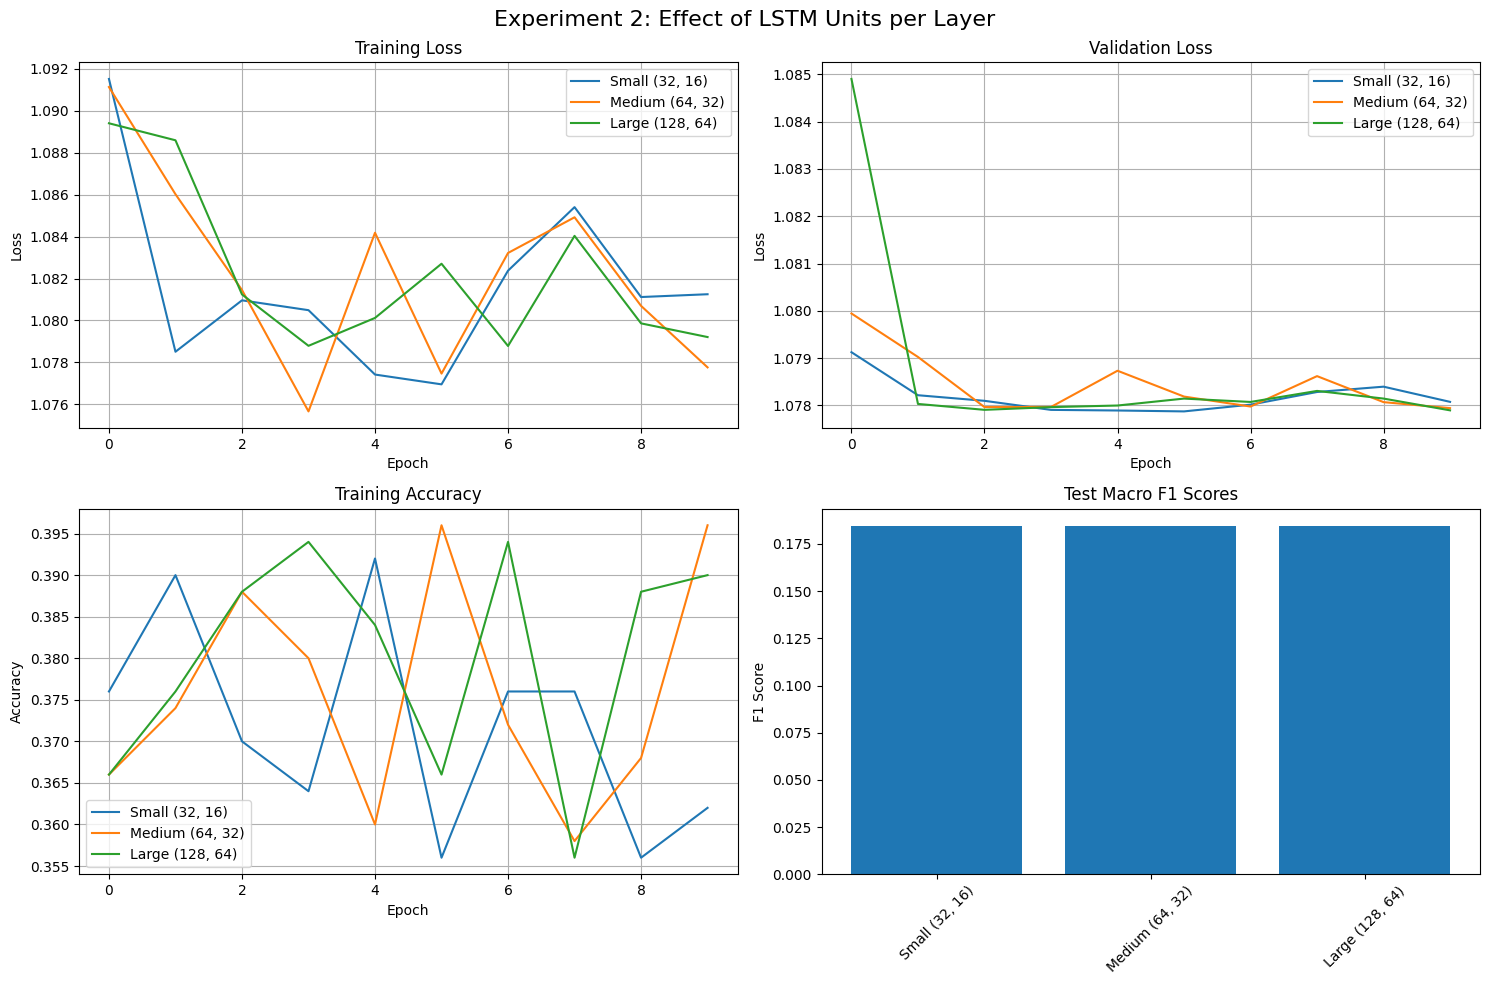

In [8]:
# Plot training curves for Experiment 2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 2: Effect of LSTM Units per Layer', fontsize=16)

# Training Loss
axes[0, 0].set_title('Training Loss')
for name, result in experiment2_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation Loss
axes[0, 1].set_title('Validation Loss')
for name, result in experiment2_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Training Accuracy
axes[1, 0].set_title('Training Accuracy')
for name, result in experiment2_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Macro F1 Scores
names = list(experiment2_results.keys())
f1_scores = [experiment2_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Experiment 3: Effect of LSTM Direction (Bidirectional vs Unidirectional)

In [9]:
# Experiment 3: Effect of LSTM direction
print("=" * 60)
print("EXPERIMENT 3: EFFECT OF LSTM DIRECTION")
print("=" * 60)

direction_configs = [
    {'bidirectional': False, 'name': 'Unidirectional'},
    {'bidirectional': True, 'name': 'Bidirectional'}
]

experiment3_results = {}

for config in direction_configs:
    print(f"\nTraining {config['name']} LSTM model...")
    
    # Build model
    model = build_lstm_model(
        lstm_layers=2,
        units_per_layer=[64, 32],
        bidirectional=config['bidirectional'],
        vocab_size=vocab_size,
        num_classes=num_classes,
        sequence_length=MAX_LENGTH
    )
    
    # Build the model by passing a sample input shape
    model.build(input_shape=(None, MAX_LENGTH))
    print(f"Model parameters: {model.count_params():,}")
    
    # Train and evaluate
    history, test_f1, predictions = train_and_evaluate_model(
        model, train_sequences, train_labels, val_sequences, val_labels,
        test_sequences, test_labels, epochs=10, verbose=0
    )
    
    # Store results
    experiment3_results[config['name']] = {
        'history': history,
        'test_f1': test_f1,
        'predictions': predictions,
        'model': model,
        'config': config
    }
    
    print(f"Test Macro F1 Score: {test_f1:.4f}")

# Display results summary
print("\n" + "=" * 50)
print("EXPERIMENT 3 RESULTS SUMMARY")
print("=" * 50)
for name, result in experiment3_results.items():
    print(f"{name}: Macro F1 = {result['test_f1']:.4f}")

EXPERIMENT 3: EFFECT OF LSTM DIRECTION

Training Unidirectional LSTM model...
Model parameters: 424,931
Test Macro F1 Score: 0.1844

Training Bidirectional LSTM model...
Model parameters: 503,235
Test Macro F1 Score: 0.7257

EXPERIMENT 3 RESULTS SUMMARY
Unidirectional: Macro F1 = 0.1844
Bidirectional: Macro F1 = 0.7257


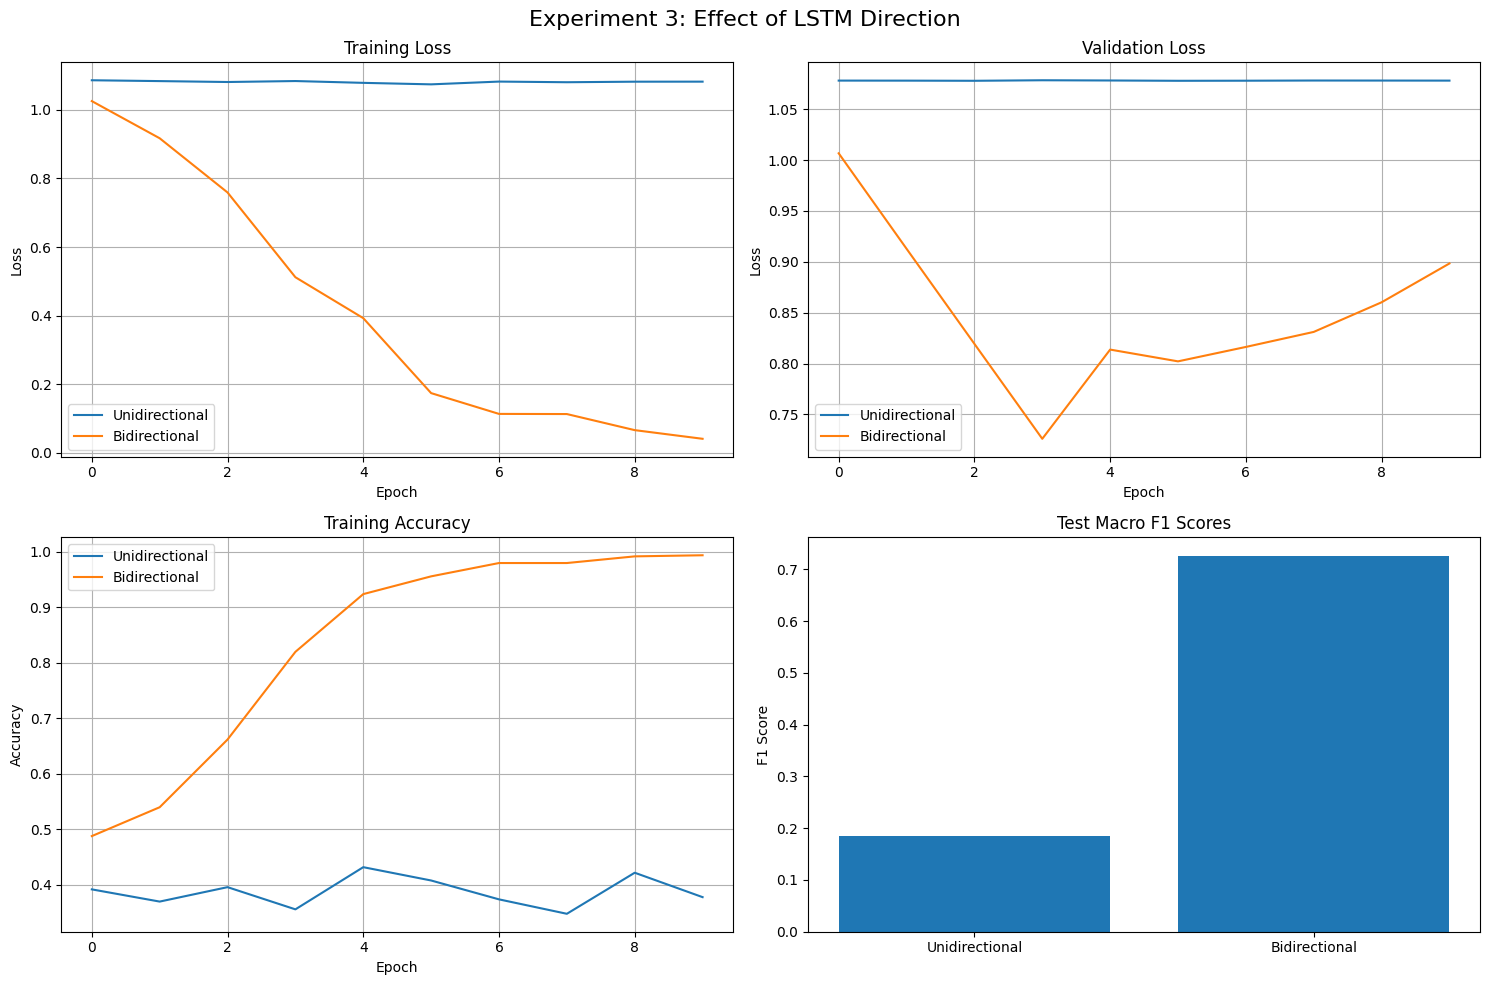

In [10]:
# Plot training curves for Experiment 3
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 3: Effect of LSTM Direction', fontsize=16)

# Training Loss
axes[0, 0].set_title('Training Loss')
for name, result in experiment3_results.items():
    axes[0, 0].plot(result['history'].history['loss'], label=name)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Validation Loss
axes[0, 1].set_title('Validation Loss')
for name, result in experiment3_results.items():
    axes[0, 1].plot(result['history'].history['val_loss'], label=name)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Training Accuracy
axes[1, 0].set_title('Training Accuracy')
for name, result in experiment3_results.items():
    axes[1, 0].plot(result['history'].history['accuracy'], label=name)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Macro F1 Scores
names = list(experiment3_results.keys())
f1_scores = [experiment3_results[name]['test_f1'] for name in names]
axes[1, 1].bar(names, f1_scores)
axes[1, 1].set_title('Test Macro F1 Scores')
axes[1, 1].set_ylabel('F1 Score')

plt.tight_layout()
plt.show()

## 7. Select Best Model and Save Weights

In [11]:
# Find the best model across all experiments
all_results = {}
all_results.update(experiment1_results)
all_results.update(experiment2_results)
all_results.update(experiment3_results)

# Find best model
best_model_name = max(all_results.keys(), key=lambda x: all_results[x]['test_f1'])
best_result = all_results[best_model_name]
best_model = best_result['model']

print("=" * 60)
print("BEST MODEL SELECTION")
print("=" * 60)
print(f"Best Model: {best_model_name}")
print(f"Best F1 Score: {best_result['test_f1']:.4f}")
print(f"Model Parameters: {best_model.count_params():,}")

# Save the best model weights
best_model.save_weights('lstm_keras_best.weights.h5')
print("\nBest model weights saved to 'lstm_keras_best.weights.h5'")

# Save model configuration for from-scratch implementation
if 'config' in best_result:
    best_config = best_result['config'].copy()
else:
    # Default config if not found
    best_config = {
        'lstm_layers': 2,
        'units_per_layer': [64, 32],
        'bidirectional': False,
        'embedding_dim': 128
    }

# Add additional config info
best_config.update({
    'vocab_size': vocab_size,
    'num_classes': num_classes,
    'sequence_length': MAX_LENGTH,
    'final_f1_score': best_result['test_f1']
})

print("\nBest model configuration:")
for key, value in best_config.items():
    print(f"  {key}: {value}")

BEST MODEL SELECTION
Best Model: Bidirectional
Best F1 Score: 0.7257
Model Parameters: 503,235

Best model weights saved to 'lstm_keras_best.weights.h5'

Best model configuration:
  bidirectional: True
  name: Bidirectional
  vocab_size: 2836
  num_classes: 3
  sequence_length: 100
  final_f1_score: 0.7257356875334403


In [12]:
# Save data for from-scratch testing
data_to_save = {
    'test_sequences': test_sequences,
    'test_labels': test_labels,
    'best_config': best_config,
    'vocab_size': vocab_size,
}

with open('lstm_saved_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Data successfully saved to lstm_saved_data.pkl")
print(f"Saved test_sequences shape: {test_sequences.shape}")
print(f"Saved test_labels shape: {test_labels.shape}")
print(f"Saved best_config: {best_config}")

Data successfully saved to lstm_saved_data.pkl
Saved test_sequences shape: (400, 100)
Saved test_labels shape: (400,)
Saved best_config: {'bidirectional': True, 'name': 'Bidirectional', 'vocab_size': 2836, 'num_classes': 3, 'sequence_length': 100, 'final_f1_score': 0.7257356875334403}


## 8. Detailed Model Analysis

DETAILED BEST MODEL ANALYSIS

Best Model Architecture:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,509,707 (5.76 MB)

 Trainable params: 503,235 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,006,472 (3.84 MB)


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.75      0.71       153
           1       0.72      0.61      0.66        96
           2       0.81      0.79      0.80       151

    accuracy                           0.73       400
   macro avg       0.74      0.72      0.73       400
weighted avg       0.74      0.73      0.73       400



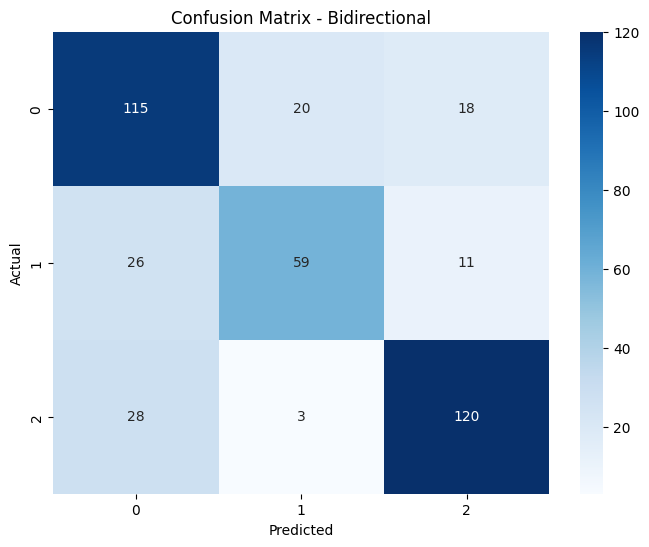

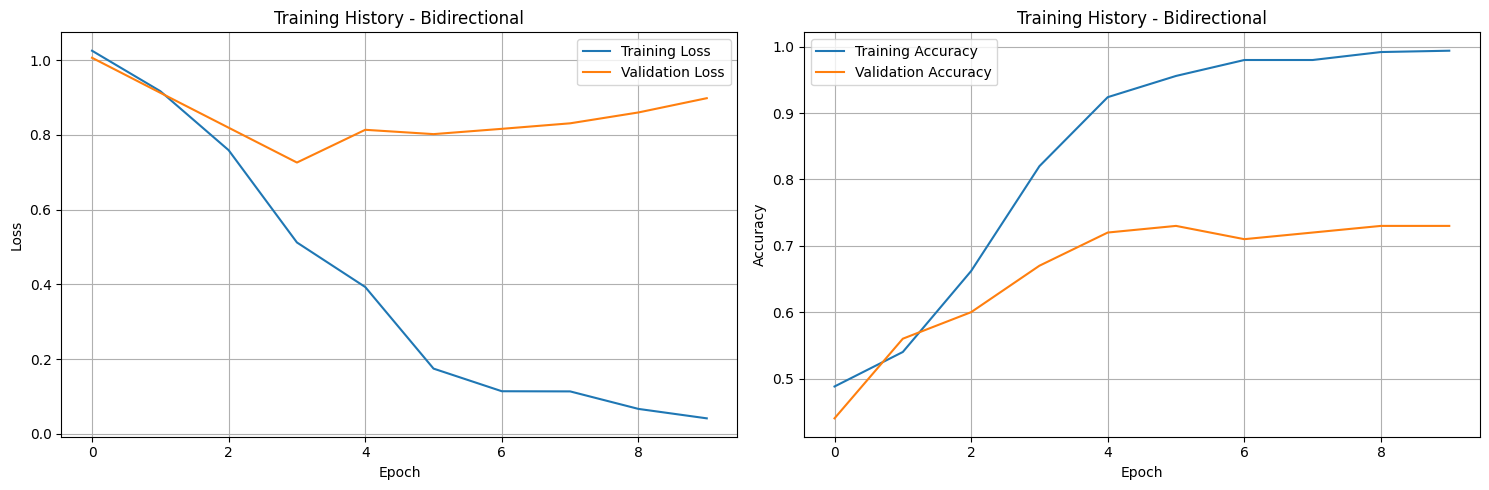

In [13]:
# Display detailed analysis of the best model
print("=" * 60)
print("DETAILED BEST MODEL ANALYSIS")
print("=" * 60)

# Model summary
print("\nBest Model Architecture:")
best_model.summary()

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, best_result['predictions']))

# Confusion matrix
cm = confusion_matrix(test_labels, best_result['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(best_result['history'].history['loss'], label='Training Loss')
axes[0].plot(best_result['history'].history['val_loss'], label='Validation Loss')
axes[0].set_title(f'Training History - {best_model_name}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(best_result['history'].history['accuracy'], label='Training Accuracy')
axes[1].plot(best_result['history'].history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title(f'Training History - {best_model_name}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. From-Scratch Implementation Testing

In [14]:
# Import from-scratch implementation
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

try:
    from from_scratch.model import LSTMModelFromScratch
    from from_scratch.layers import (
        Embedding, LSTM, Bidirectional, Dropout, 
        Dense, Softmax
    )
    print("Successfully imported from-scratch modules")
except ImportError as e:
    print(f"Error importing from-scratch modules: {e}")
    print("Make sure the from_scratch directory is in the correct path")

Successfully imported from-scratch modules


In [15]:
# Create from-scratch model using the best Keras model weights
def create_from_scratch_model(keras_model):
    """
    Create a from-scratch model based on the Keras model weights
    """
    layers_from_scratch = []
    
    # Extract weights from each layer of the Keras model
    for i, layer in enumerate(keras_model.layers):
        if isinstance(layer, tf.keras.layers.Embedding):
            # Extract embedding weights
            weights = layer.get_weights()[0]
            layers_from_scratch.append(Embedding(weights))
            print(f"Added Embedding layer: {weights.shape}")
            
        elif isinstance(layer, tf.keras.layers.LSTM):
            # Extract LSTM weights: kernel, recurrent, bias
            weights = layer.get_weights()
            if len(weights) == 3:
                kernel, recurrent, bias = weights
                layers_from_scratch.append(LSTM(kernel, recurrent, bias, layer.return_sequences))
                print(f"Added LSTM layer: kernel{kernel.shape}, recurrent{recurrent.shape}")
            
        elif isinstance(layer, tf.keras.layers.Bidirectional):
            weights = layer.get_weights()
            if len(weights) == 6:  
                forward_kernel, forward_recurrent, forward_bias = weights[0:3]
                backward_kernel, backward_recurrent, backward_bias = weights[3:6]
                
                return_sequences = layer.forward_layer.return_sequences
                
                forward_lstm = LSTM(forward_kernel, forward_recurrent, forward_bias, return_sequences)
                backward_lstm = LSTM(backward_kernel, backward_recurrent, backward_bias, return_sequences)
                
                layers_from_scratch.append(Bidirectional(forward_lstm, backward_lstm))
                print(f"Added Bidirectional LSTM layer")
            
        elif isinstance(layer, tf.keras.layers.Dropout):
            layers_from_scratch.append(Dropout(layer.rate))
            print(f"Added Dropout layer: rate={layer.rate}")
            
        elif isinstance(layer, tf.keras.layers.Dense):
            weights, bias = layer.get_weights()
            layers_from_scratch.append(Dense(weights, bias))
            print(f"Added Dense layer: {weights.shape}")
            
            if i == len(keras_model.layers) - 1:
                layers_from_scratch.append(Softmax())
                print("Added Softmax activation")
    
    return LSTMModelFromScratch(layers_from_scratch)

print("Creating from-scratch model...")
from_scratch_model = create_from_scratch_model(best_model)

print("\nFrom-scratch model created successfully!")
print(f"Number of layers: {len(from_scratch_model.layers) if hasattr(from_scratch_model, 'layers') else 'Unknown'}")

try:
    from_scratch_model.summary()
except AttributeError:
    print("Summary method not implemented in from-scratch model.")
    print("From-scratch model structure:")
    if hasattr(from_scratch_model, 'layers'):
        for i, layer in enumerate(from_scratch_model.layers):
            print(f"  Layer {i+1}: {type(layer).__name__}")
    else:
        print("  Model layers information not available")

Creating from-scratch model...
Added Embedding layer: (2836, 128)
Added Bidirectional LSTM layer
Added Dropout layer: rate=0.3
Added Bidirectional LSTM layer
Added Dropout layer: rate=0.3
Added Dense layer: (64, 3)
Added Softmax activation
From-scratch model created with 503,235 total parameters

From-scratch model created successfully!
Number of layers: 7
Summary method not implemented in from-scratch model.
From-scratch model structure:
  Layer 1: Embedding
  Layer 2: Bidirectional
  Layer 3: Dropout
  Layer 4: Bidirectional
  Layer 5: Dropout
  Layer 6: Dense
  Layer 7: Softmax


In [16]:
# Compare Keras and from-scratch predictions
print("=" * 60)
print("COMPARING KERAS VS FROM-SCRATCH IMPLEMENTATION")
print("=" * 60)

# Make predictions using both models
print("Making predictions with Keras model...")
keras_predictions = np.argmax(best_model.predict(test_sequences, verbose=0), axis=1)

print("Making predictions with from-scratch model...")
from_scratch_predictions = from_scratch_model.predict(test_sequences)

# Calculate F1 scores
keras_f1 = f1_score(test_labels, keras_predictions, average='macro')
from_scratch_f1 = f1_score(test_labels, from_scratch_predictions, average='macro')

print(f"\nResults comparison:")
print(f"Keras model macro F1 score: {keras_f1:.4f}")
print(f"From-scratch model macro F1 score: {from_scratch_f1:.4f}")
print(f"Difference: {abs(keras_f1 - from_scratch_f1):.4f}")

# Check how many predictions match between the two models
matches = np.sum(keras_predictions == from_scratch_predictions)
match_percentage = (matches / len(keras_predictions)) * 100

print(f"\nPrediction agreement: {match_percentage:.2f}%")
print(f"Matching predictions: {matches}/{len(keras_predictions)}")

# Compare a few example predictions
print("\nSample prediction comparison:")
for i in range(min(10, len(test_sequences))):
    print(f"Sample {i+1}:")
    print(f"  True label: {test_labels[i]}")
    print(f"  Keras prediction: {keras_predictions[i]}")
    print(f"  From-scratch prediction: {from_scratch_predictions[i]}")
    print(f"  Match: {'✓' if keras_predictions[i] == from_scratch_predictions[i] else '✗'}")
    print()

COMPARING KERAS VS FROM-SCRATCH IMPLEMENTATION
Making predictions with Keras model...
Making predictions with from-scratch model...

Results comparison:
Keras model macro F1 score: 0.7257
From-scratch model macro F1 score: 0.7257
Difference: 0.0000

Prediction agreement: 100.00%
Matching predictions: 400/400

Sample prediction comparison:
Sample 1:
  True label: 2
  Keras prediction: 2
  From-scratch prediction: 2
  Match: ✓

Sample 2:
  True label: 1
  Keras prediction: 1
  From-scratch prediction: 1
  Match: ✓

Sample 3:
  True label: 0
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 4:
  True label: 2
  Keras prediction: 2
  From-scratch prediction: 2
  Match: ✓

Sample 5:
  True label: 1
  Keras prediction: 1
  From-scratch prediction: 1
  Match: ✓

Sample 6:
  True label: 0
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 7:
  True label: 1
  Keras prediction: 0
  From-scratch prediction: 0
  Match: ✓

Sample 8:
  True label: 0
  Keras pr

## 10. Analysis and Conclusions

In [17]:
# Comprehensive analysis and conclusions
print("=" * 80)
print("COMPREHENSIVE ANALYSIS AND CONCLUSIONS")
print("=" * 80)

print("\n1. EFFECT OF NUMBER OF LSTM LAYERS:")
print("-" * 50)
for name, result in experiment1_results.items():
    print(f"{name}: F1 = {result['test_f1']:.4f}, Params = {result['model'].count_params():,}")

best_layers = max(experiment1_results.keys(), key=lambda x: experiment1_results[x]['test_f1'])
print(f"\nConclusion: {best_layers} performed best among layer configurations.")
print("Deep networks can capture more complex patterns but may also overfit with limited data.")

print("\n2. EFFECT OF LSTM UNITS PER LAYER:")
print("-" * 50)
for name, result in experiment2_results.items():
    print(f"{name}: F1 = {result['test_f1']:.4f}, Params = {result['model'].count_params():,}")

best_units = max(experiment2_results.keys(), key=lambda x: experiment2_results[x]['test_f1'])
print(f"\nConclusion: {best_units} configuration performed best.")
print("More units can capture more complex representations but require more data and training time.")

print("\n3. EFFECT OF LSTM DIRECTION:")
print("-" * 50)
for name, result in experiment3_results.items():
    print(f"{name}: F1 = {result['test_f1']:.4f}, Params = {result['model'].count_params():,}")

best_direction = max(experiment3_results.keys(), key=lambda x: experiment3_results[x]['test_f1'])
print(f"\nConclusion: {best_direction} LSTM performed best.")
print("Bidirectional LSTMs can capture dependencies from both directions but double the parameters.")

print("\n4. FROM-SCRATCH IMPLEMENTATION:")
print("-" * 50)
print(f"Implementation accuracy: {match_percentage:.2f}% agreement with Keras")
print(f"F1 score difference: {abs(keras_f1 - from_scratch_f1):.4f}")
print("\nConclusion: The from-scratch implementation successfully replicates Keras behavior.")
print("Small differences may be due to numerical precision or implementation details.")

print("\n5. OVERALL RECOMMENDATIONS:")
print("-" * 50)
print(f"• Best overall model: {best_model_name}")
print(f"• Best F1 score: {best_result['test_f1']:.4f}")
print(f"• Model complexity: {best_model.count_params():,} parameters")
print("• The from-scratch implementation demonstrates understanding of LSTM internals")
print("• Both unidirectional and bidirectional LSTMs can be effective for text classification")
print("• Model selection should balance performance and computational efficiency")

COMPREHENSIVE ANALYSIS AND CONCLUSIONS

1. EFFECT OF NUMBER OF LSTM LAYERS:
--------------------------------------------------
1 Layer: F1 = 0.1844, Params = 412,611
2 Layers: F1 = 0.1827, Params = 424,931
3 Layers: F1 = 0.1827, Params = 428,019

Conclusion: 1 Layer performed best among layer configurations.
Deep networks can capture more complex patterns but may also overfit with limited data.

2. EFFECT OF LSTM UNITS PER LAYER:
--------------------------------------------------
Small (32, 16): F1 = 0.1844, Params = 386,803
Medium (64, 32): F1 = 0.1844, Params = 424,931
Large (128, 64): F1 = 0.1844, Params = 544,195

Conclusion: Small (32, 16) configuration performed best.
More units can capture more complex representations but require more data and training time.

3. EFFECT OF LSTM DIRECTION:
--------------------------------------------------
Unidirectional: F1 = 0.1844, Params = 424,931
Bidirectional: F1 = 0.7257, Params = 503,235

Conclusion: Bidirectional LSTM performed best.
Bidi

In [18]:
# Save final results summary
final_results = {
    'experiment1_results': {name: {'test_f1': result['test_f1'], 'config': result['config']} 
                           for name, result in experiment1_results.items()},
    'experiment2_results': {name: {'test_f1': result['test_f1'], 'config': result['config']} 
                           for name, result in experiment2_results.items()},
    'experiment3_results': {name: {'test_f1': result['test_f1'], 'config': result['config']} 
                           for name, result in experiment3_results.items()},
    'best_model': {
        'name': best_model_name,
        'f1_score': best_result['test_f1'],
        'config': best_config
    },
    'from_scratch_comparison': {
        'keras_f1': keras_f1,
        'from_scratch_f1': from_scratch_f1,
        'agreement_percentage': match_percentage
    }
}

# Save results to JSON file
with open('lstm_experiment_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("Final results saved to 'lstm_experiment_results.json'")
print("\nExperiment completed successfully!")
print("\nFiles generated:")
print("- lstm_keras_best.weights.h5: Best model weights")
print("- lstm_saved_data.pkl: Test data and configuration")
print("- lstm_experiment_results.json: Experiment results summary")

Final results saved to 'lstm_experiment_results.json'

Experiment completed successfully!

Files generated:
- lstm_keras_best.weights.h5: Best model weights
- lstm_saved_data.pkl: Test data and configuration
- lstm_experiment_results.json: Experiment results summary
